In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import pickle


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('MountainCarContinuous-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Turn interactive mode on.
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cuda for simulation.


### Model Architecture

In [2]:
class Actor_Network(nn.Module):
    def __init__(self, input_size=2, hidden_size=256, output_size=1):
        super(Actor_Network, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        # Note the 2 below is a scalar for the action space range.
        x = torch.tanh(self.linear3(x))
        return x
    
class Critic_Network(nn.Module):
    '''A Deep Q network for predicting actions given states'''
    def __init__(self, state, action, hidden1=400, hidden2=300):
        super(Critic_Network, self).__init__()
        self.FCL1 = nn.Linear(state,hidden1)
        self.FCL2 = nn.Linear(hidden1+action, hidden2)
        self.FCL3 = nn.Linear(hidden2,1)
    
    def reset_parameters(self):
        self.FCL1.weight.data.uniform_(-3e-3, 3e-3)
        self.FCL2.weight.data.uniform_(-3e-3, 3e-3)
        self.FCL3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        '''input stateaction, output value'''
        x = F.relu(self.FCL1(state))
        x = self.FCL2(torch.cat([x,action],dim=1))
        x = F.relu(x)
        x = self.FCL3(x)
        return x

### Memory Buffer

In [3]:
'''A mapping of state-action pairs to next-state reward results'''
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'isDone'))


class ReplayMemory(object):
    '''a cyclic buffer of bounded size that holds recently observed transitions.'''

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            # if we are at less than capacity, allocate fresh space for the transition
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        '''Randomly return a batch of batch_size from the memory'''
        return random.sample(self.memory, batch_size)
    
    def get_item(self, memloc):
        '''Show Transition stored at memloc'''
        return self.memory[memloc]
    
    def clear(self):
        '''Clear the memory buffer'''
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)
    
    def save(self):
        ''' Save memory buffer to a file.'''
        file = open('replay_buffer.obj', 'wb')
        pickle.dump(self.memory, file)
        file.close()

    def load(self):
        '''Import a saved memory buffer.'''
        try:
            filehandler = open('replay_buffer.obj', 'rb')
            self.memory = pickle.load(filehandler)
            self.position = len(self.buffer)
        except:
            print('there was no file to load')

### Action selection and parameter updates

In [4]:
def select_action(state):
    '''torch.tensor -> torch.tensor
    
    Chooses an greedy action given an input state.
    
    state: State vector
    returns:
    action: action vector
    '''
    
    if len(memory) < BATCH_SIZE:
        action = env.action_space.sample()
    else:
        action = policy_actor_net(state).detach()
        action = action.squeeze(0).cpu().numpy()
    return action

def soft_update(target, source, tau=0.005):
    """
    update target neural net parameters by:
        target = tau * source + (1 - tau) * target
    target: Target network
    source: source network
    tau: 0 < tau << 1 (float)
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )    
    
def optimize_model():
    '''
    None -> float,float
    
    Update the actor and critic networks via SGD.
    returns actor loss and critic loss.
    '''
    if len(memory) < BATCH_SIZE:
        #We do not have enough history in memory to optimize our network
        return 0, 0
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch 
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)
    
    next_action_batch = target_actor_net(next_state_batch).detach()
    target_q = target_critic_net(next_state_batch, next_action_batch).detach()
    y_expected = reward_batch + gamma*target_q
    y_predicted = policy_critic_net(state_batch, action_batch)

    # critic gradient
    critic_loss = nn.MSELoss()
    loss_critic = critic_loss(y_predicted, y_expected)
    critic_optimizer.zero_grad()
    loss_critic.backward()
    critic_optimizer.step()
    
    # actor gradient
    policy_loss = -policy_critic_net.forward(state_batch, policy_actor_net.forward(state_batch)).mean()
    actor_optimizer.zero_grad()
    policy_loss.backward()
    actor_optimizer.step()
    
    soft_update(target_actor_net, policy_actor_net, tau=0.01)
    soft_update(target_critic_net, policy_critic_net, tau=0.01)
    
    return policy_loss.item(), loss_critic.item()   

### Noise Functions

In [5]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

### Plotting functions

In [6]:
def plot_reward(reward_input, pngout=False, pngpath='ouput.png'):
    '''
    List -> matplotlib.plt

    pngout (bool):  Save reward as png file.
    pngpath (str):  Location to save png file.


    Show the reward per episode on the yaxis.
    After 100 episodes also plot a moving average.
    '''
    plt.figure(2,dpi=300) 
    durations_t = torch.tensor(reward_input, dtype=torch.float)
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t)
    if pngout:
        plt.savefig(pngpath)
    else:
        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            display.clear_output(wait=True)

### Initialisation

In [7]:
# Get length of action and observation space from gym
n_actions = env.action_space.shape[0]
n_states = env.observation_space.shape[0]

# Create two actor networks
policy_actor_net = Actor_Network(input_size=n_states, output_size=n_actions).to(device)
target_actor_net = Actor_Network(input_size=n_states, output_size=n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_actor_net.load_state_dict(policy_actor_net.state_dict())

# Create two critic networks
policy_critic_net = Critic_Network(n_states, n_actions).to(device)
target_critic_net = Critic_Network(n_states, n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_critic_net.load_state_dict(policy_critic_net.state_dict())

memory = ReplayMemory(50000)
memory.clear()

# Initialise noise generator
noise = OUNoise(env.action_space)

#Optimizer for the policy networks. These are Updated by SGD.
actor_optimizer = optim.Adam(policy_actor_net.parameters(),lr=0.0001)
critic_optimizer = optim.Adam(policy_critic_net.parameters(),lr=0.001)

steps_done = 0
episode_durations = []
reward_values = []
action_values=[]
frame_values=[]
env.close()


### Hyperparameters

In [8]:
BATCH_SIZE = 128
gamma=0.99

plot=True
render=True

debug_action=False
debug_noise=False
debug_loss=False

### Runtime

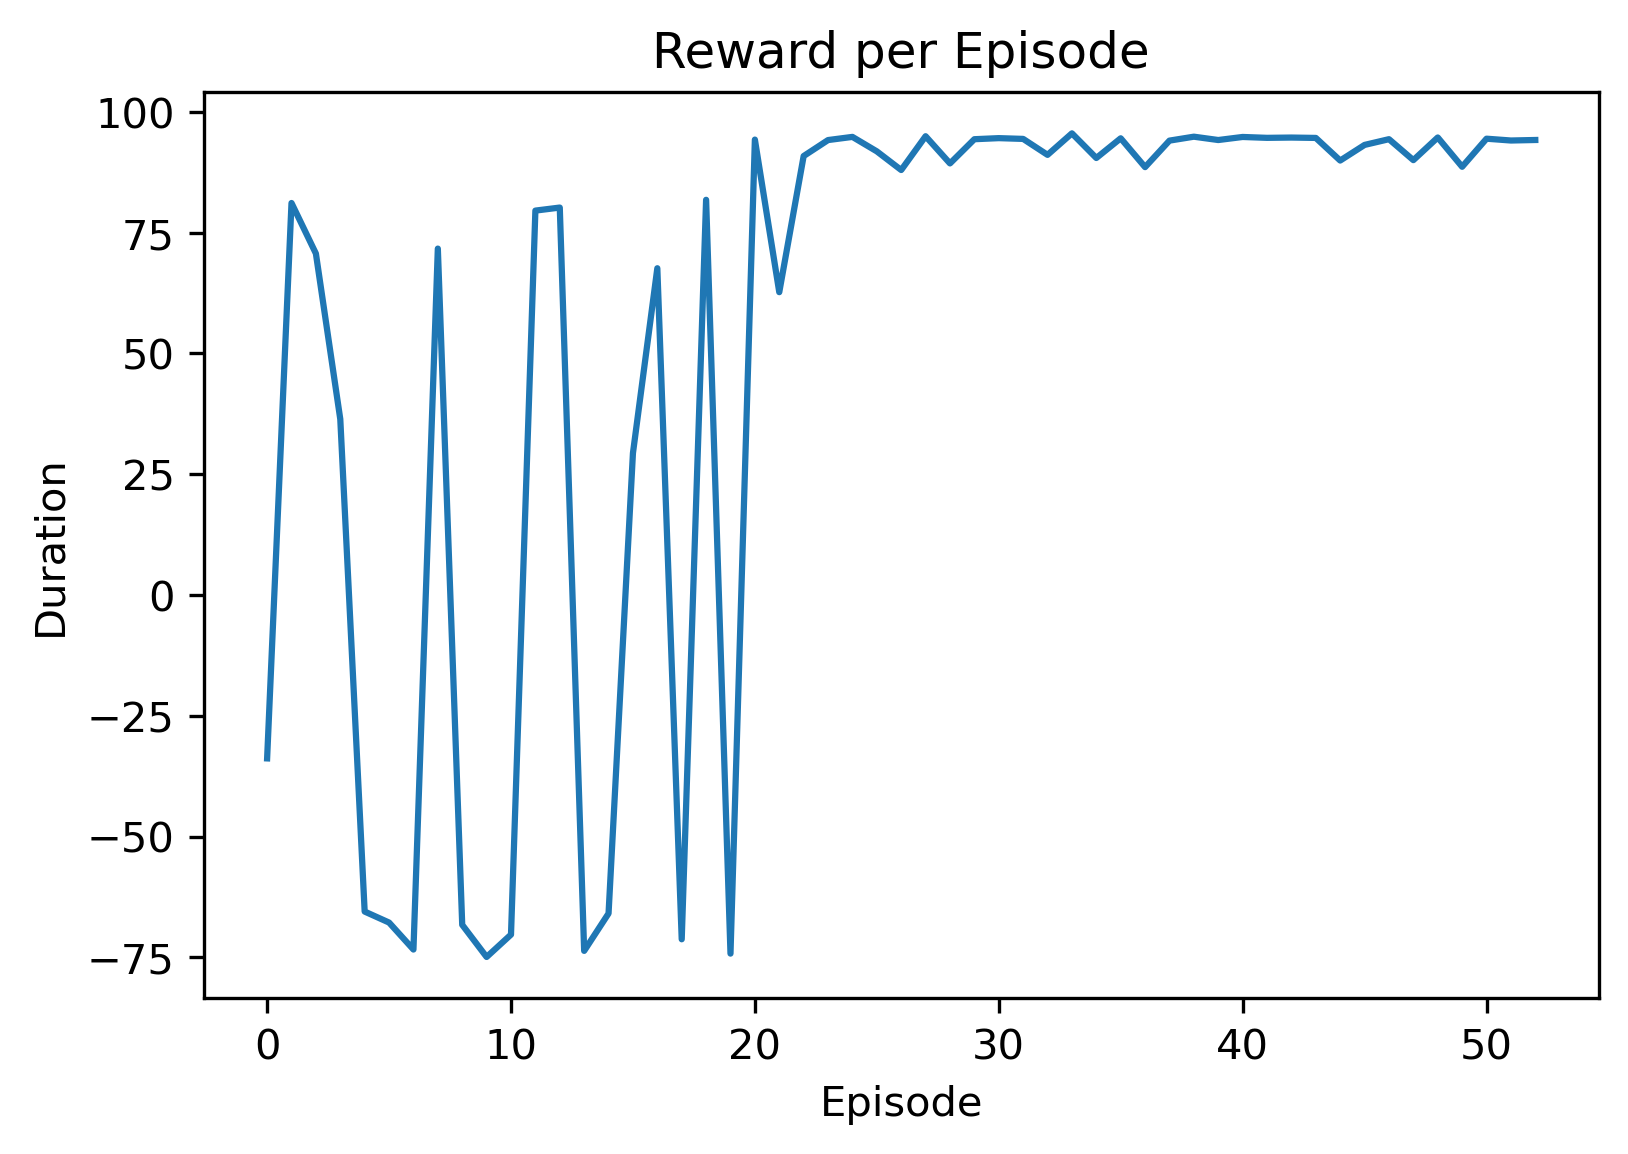

In [12]:
save_states=1000
num_episodes=50
for i_episode in range(num_episodes):
    state = torch.from_numpy(np.cast['float32'](env.reset())).unsqueeze(0).to(device)
    TotalReward=0
    aLoss = []
    cLoss = []
    episode_frames=[]
    noise.reset()
    for t in count():
        action = select_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = env.step(action)
        
        if render:
            env.render()
        if i_episode % save_states == 0:
            episode_frames.append(env.render(mode = 'rgb_array'))

        TotalReward+= reward
        action = torch.from_numpy(np.cast['float32'](action)).unsqueeze(0).to(device)
        next_state = torch.from_numpy(np.cast['float32'](next_state)).unsqueeze(0).to(device)
        reward = torch.tensor([reward], device=device,dtype=torch.float32).unsqueeze(0).to(device)

        if not done:
            isDone = 0
        else:
            isDone = 1 
        isDone = torch.tensor([isDone], device=device,dtype=torch.float32).unsqueeze(0).to(device)
        memory.push(state, action, next_state, reward, isDone)
        
        state = next_state

        # Perform one step of the optimization
        actor_loss, critic_loss = optimize_model()
        aLoss.append(actor_loss)
        cLoss.append(critic_loss)
        
        if debug_loss:
            print ("ALoss: ", np.round(actor_loss,decimals=3), "CLoss:", np.round(critic_loss,decimals=3))
        
        if done:
            episode_durations.append(t + 1)
            reward_values.append(TotalReward)
            if plot:
                plot_reward(reward_values)
            break
    if i_episode % save_states == 0:
        frame_values.append(episode_frames)

        
#env.render()
env.close()
#plt.ioff()
#plt.show()
if plot:
    plot_reward(reward_values)
    
#plt.plot(cLoss)
#plt.plot(aLoss)
#plt.show()

In [ ]:
plt.plot(cLoss)
#plt.plot(aLoss[5:])
plt.show()

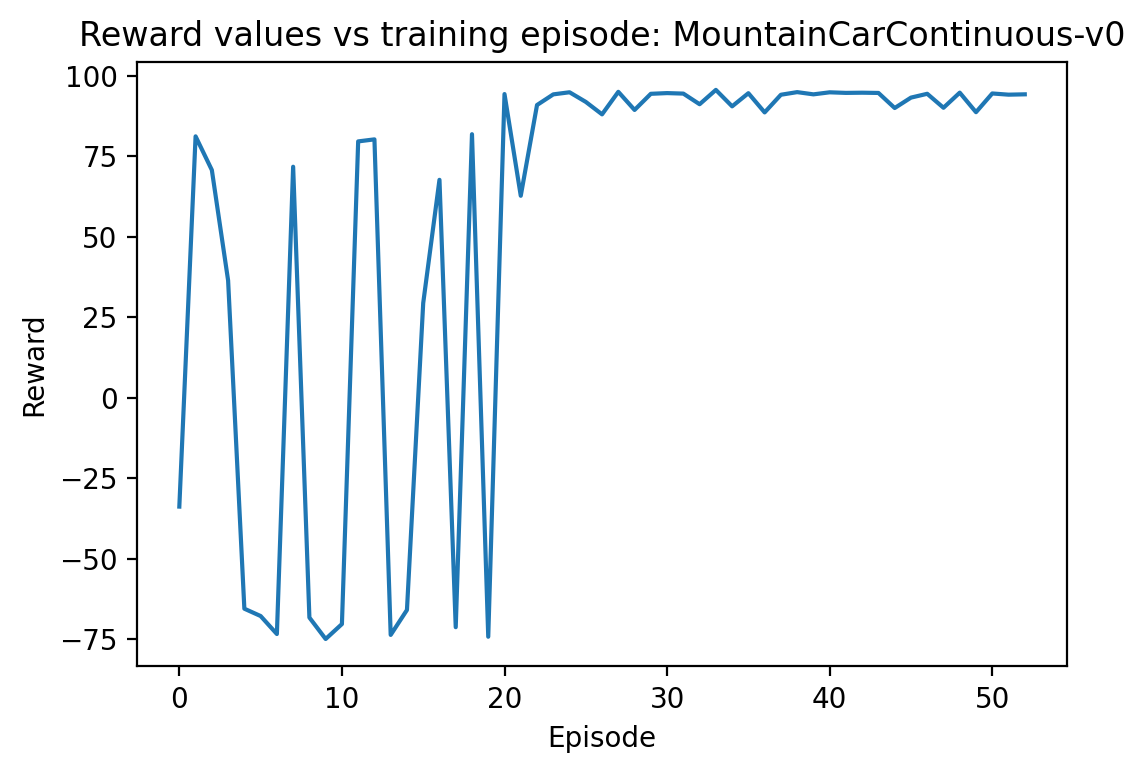

In [13]:
def save_reward(reward_values):
    '''Show the reward per episode on the yaxis..
    '''
    plt.figure(2,dpi=200) 
    #plt.clf()
    reward_values = torch.tensor(reward_values, dtype=torch.float)
    plt.title('Reward values vs training episode: MountainCarContinuous-v0')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(reward_values)
    plt.savefig('plots/MCC/RewardperEp.png')

save_reward(reward_values)